Paper Link: https://arxiv.org/pdf/1506.02640.pdf

We have overfitted the yolov1 model with only 20 training images. 

In [1]:
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#Loading data

In [3]:
image_folder = '/content/drive/MyDrive/DL/object_detection2/2000images'
label_folder = '/content/drive/MyDrive/DL/object_detection2/2000labels'

image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
image_files.sort()

label_files = [os.path.join(label_folder, lbl) for lbl in os.listdir(label_folder)]
label_files.sort()

images = []
item = 0

for img in image_files:
  item +=1
  image_arr = cv2.imread(img)
  image_arr = cv2.resize(image_arr, (448,448))  
  image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
  images.append(image_arr)
  if item >= 30:
    break

#converting them to numpy array:
images = np.array(images)

labels = []
i = 0
for lbl in label_files:
  i += 1
  boxtemp = []
  r = open(lbl)
  for line in r:
    line = line.rstrip()
    l = list(line.split(" "))
    btemp = []
    for element in l:
      btemp.append(float(element))
    boxtemp.append(btemp)
  
  labels.append(np.array(boxtemp))
  if i >=30:
    break


In [4]:
image_disp = images.copy()

In [5]:
classes = {
    0: 'aeroplane',  1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car',
    7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike',
    14: 'person', 15: 'pottedplant', 16: 'sheep' , 17: 'sofa', 18: 'train', 19: 'tvmonitor' }


In [6]:
from google.colab.patches import cv2_imshow

def draw_box(image, box): #inputs are numpy array, Function to display image with it's bounding boxes
  img = image.copy()
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  for b in box:
    x = b[1]
    y = b[2]
    w = b[3]
    h = b[4]

    x1 = int( (x - w/2)*448 )
    y1 = int( (y - h/2)*448 )
    x2 = int( (x + w/2)*448 )
    y2 = int( (y + h/2)*448 )
    
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(img, classes[int(b[0])], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (26,269,0), 2)

  cv2_imshow(img)
  cv2.waitKey(0)
  return



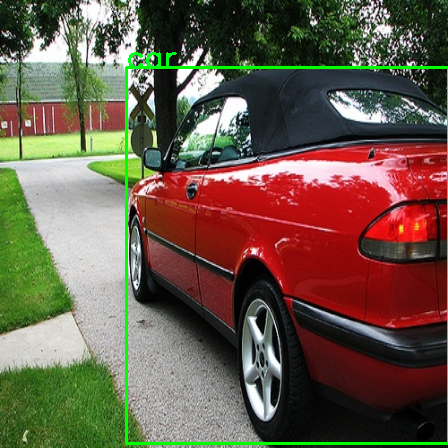

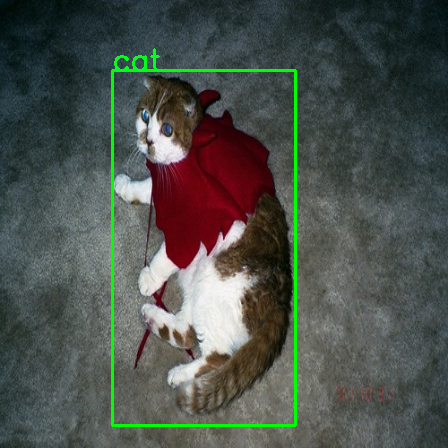

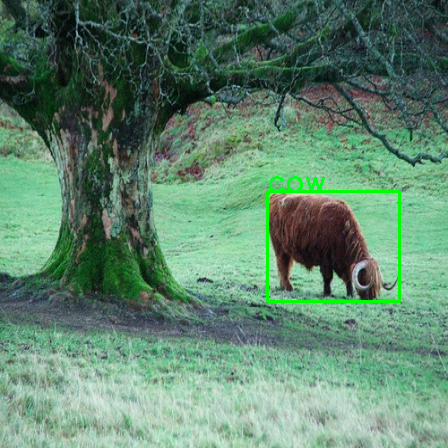

In [7]:
draw_box(images[6], labels[6])
draw_box(images[10], labels[10])
draw_box(images[12], labels[12])

In [8]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [9]:
images = torch.tensor(images, dtype = torch.float32, device= DEVICE)
images = images/(torch.max(images))

In [10]:
images = images.permute(0, 3, 1, 2)

#creating output matrix for calculating loss:

In [11]:
box_out = torch.zeros((images.shape[0], 7,7, 30), dtype = torch.float32, device = DEVICE)
for i in range(images.shape[0]):
  for box in labels[i]:
    column = int(box[1]*7)
    row = int(box[2]*7)
    box_out[i,row, column, 20] = 1
    box_out[i,row, column, 21:25] = torch.tensor(np.array([ (box[1]*7 - column), (box[2]*7 - row), 7*box[3], 7*box[4] ]))
    box_out[i,row, column, int(box[0])] = 1


#model architecture

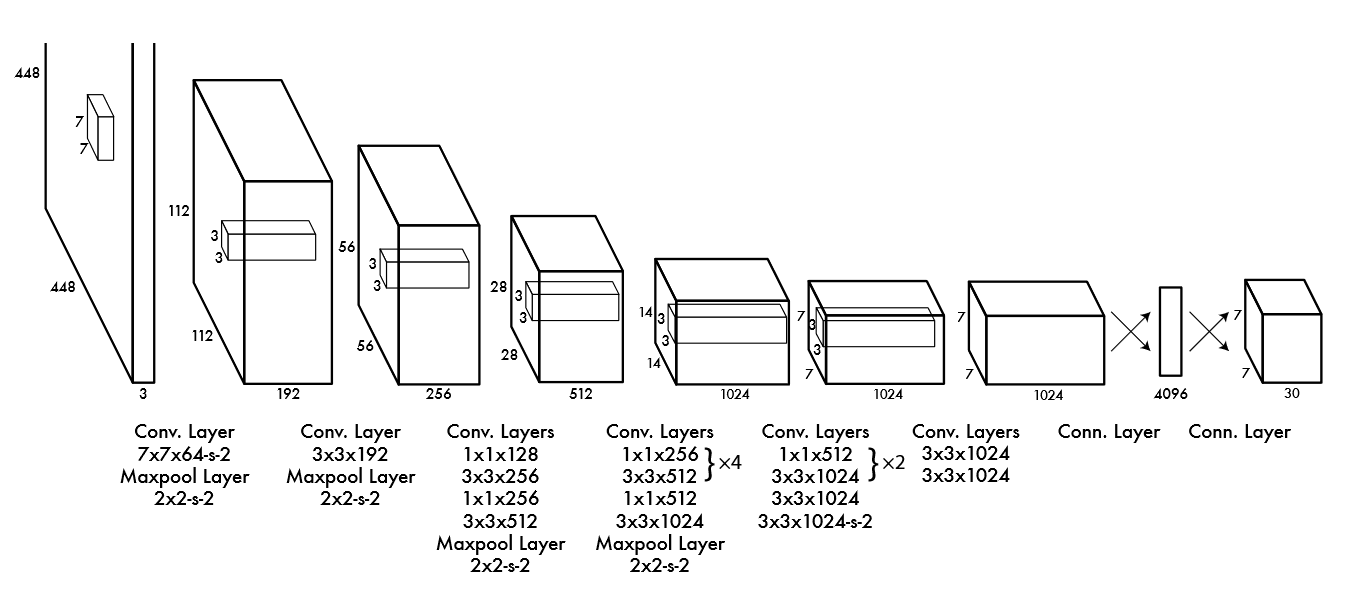

In [12]:
class YOLO(nn.Module):

  def __init__(self, in_channels, num_splits): 
    super(YOLO, self).__init__()
    self.num_splits = num_splits
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7,2 , 3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, 3,1 , 1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.conv3 = nn.Sequential(
            nn.Conv2d(192, 128, 1 ,1 , 0),
            nn.Conv2d(128, 256, 3,1 , 1),
            nn.Conv2d(256, 256, 1 ,1 , 0),
            nn.Conv2d(256, 512, 3,1 , 1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.conv4 = nn.Sequential(
            nn.Conv2d(512, 256, 1 ,1 , 0),
            nn.Conv2d(256, 512, 3,1 , 1),
            nn.Conv2d(512, 256, 1 ,1 , 0),
            nn.Conv2d(256, 512, 3,1 , 1),
            nn.Conv2d(512, 256, 1 ,1 , 0),
            nn.Conv2d(256, 512, 3,1 , 1),
            nn.Conv2d(512, 256, 1 ,1 , 0),
            nn.Conv2d(256, 512, 3,1 , 1),

            nn.Conv2d(512, 512, 1 ,1 , 0),
            nn.Conv2d(512, 1024, 3,1 , 1),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.conv5 = nn.Sequential(
            nn.Conv2d(1024, 512, 1 ,1 , 0),
            nn.Conv2d(512, 1024, 3,1 , 1),

            nn.Conv2d(1024, 512, 1 ,1 , 0),
            nn.Conv2d(512, 1024, 3,1 , 1),

            nn.Conv2d(1024, 1024, 3,1 , 1),

            nn.Conv2d(1024, 1024, 3,2 , 1),
        )
    
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3,1 , 1),
            nn.Conv2d(1024, 1024, 3,1 , 1),
        )
    
    #fully connected layers:
    self.linear1 = nn.Linear(1024*7*7, 4096)
    self.relu1 = nn.ReLU()

    self.linear2 = nn.Linear(4096, 30*num_splits*num_splits)
    
  def forward(self, input):
    out = self.conv1(input)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.conv6(out)

    out = out.reshape(input.shape[0], -1)
    out = self.linear1(out)
    out = self.relu1(out)
    out = self.linear2(out)

    #reshaping:
    out = out.reshape(input.shape[0], self.num_splits, self.num_splits, 30)
   #print(out.shape)
    return out


In [13]:
yolo = YOLO(3,7).to(device= DEVICE)

In [14]:

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

#Loss function

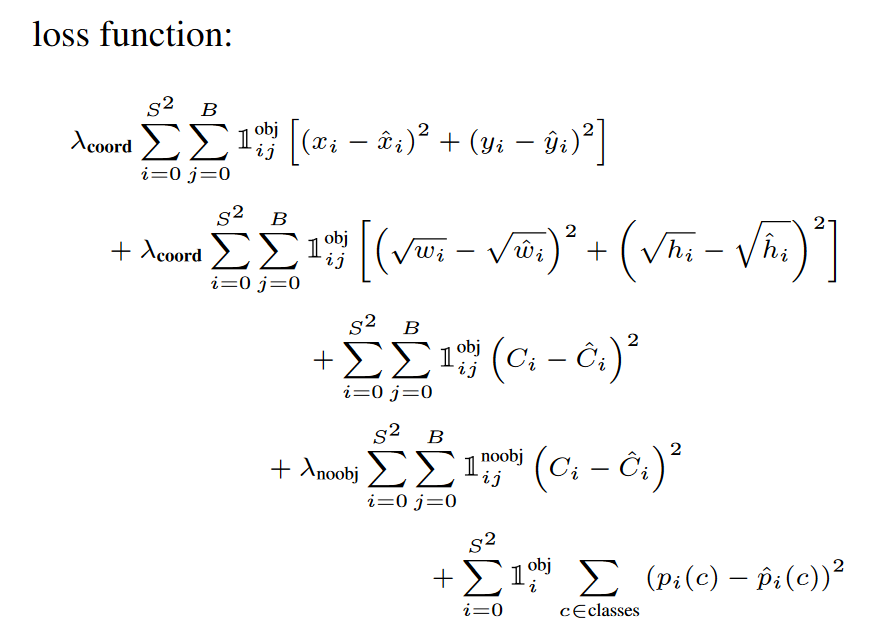

In [15]:

class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        target = target.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [16]:
lossfunc = YoloLoss(S=7, B=2, C=20)

#Training the function:

In [17]:
optimizer = torch.optim.Adam(yolo.parameters(), lr=0.0002)        #update the weights of the model 
loss_type = torch.nn.L1Loss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 2, gamma = 0.8)   #Every every step_size the learning rate will be multiplied by gamma

In [18]:
from torch.utils.data import Dataset, DataLoader     #Importing pytorch Dataloader

In [19]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding bounding boxes
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [20]:
data = CustomImageDataset(images, box_out)  #data is the object for the class that takes index and gives data and it's mask

In [21]:
batchsize = 12
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [158]:
#Model Training
loss_graph = []
num_epochs = 10  #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches

folder_save_model = '/content/drive/MyDrive/DL/saved_weights'
iter = -1
for j in range(num_epochs):
  print("----------------------------------------------")

  yolo.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):
    iter += 1
    optimizer.zero_grad()
    y_pred = yolo(x_batch)
  
    loss = lossfunc(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

  print("loss at iter: ", iter, " is: ", loss.item())
  step_lr.step()
  PATH = os.path.join(folder_save_model, 'model' + str(j))
  torch.save(yolo.state_dict(), PATH)
  



----------------------------------------------
loss at iter:  2  is:  36.46635818481445
----------------------------------------------
loss at iter:  5  is:  35.348995208740234
----------------------------------------------
loss at iter:  8  is:  54.16851806640625
----------------------------------------------
loss at iter:  11  is:  42.00245666503906
----------------------------------------------
loss at iter:  14  is:  20.548046112060547
----------------------------------------------
loss at iter:  17  is:  48.14630126953125
----------------------------------------------
loss at iter:  20  is:  56.00049591064453
----------------------------------------------
loss at iter:  23  is:  24.848163604736328
----------------------------------------------
loss at iter:  26  is:  31.454708099365234
----------------------------------------------
loss at iter:  29  is:  43.98628234863281


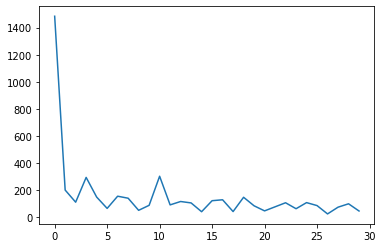

In [117]:
#Loss Graph:
plt.plot(loss_graph)
plt.show()

In [183]:
#loading saved models:
PATH = os.path.join(folder_save_model, 'model5')
yolo.load_state_dict(torch.load(PATH))
yolo.eval()

YOLO(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv

In [184]:
out = yolo(images[10:12])

In [185]:
#Let's see the predictions:
for i in range(out.shape[1]):
  for j in range(out.shape[2]):
    if out[0,i,j,20] > 0.4:
      print(i,j)
      

3 3


In [186]:
box_out[10,3,3, 20:25]

tensor([1.0000, 0.1920, 0.8781, 2.8560, 5.5525], device='cuda:0')

In [187]:
out[0,3,3, 20:25]

tensor([0.5025, 0.6602, 0.7907, 3.7652, 4.6104], device='cuda:0',
       grad_fn=<SliceBackward0>)

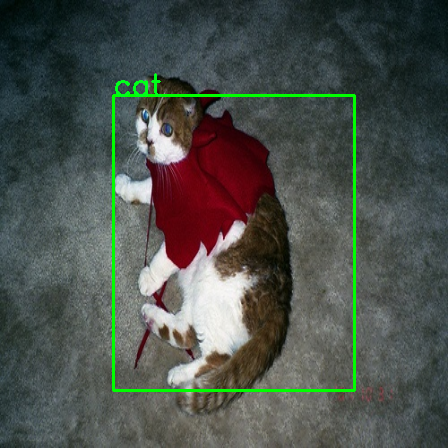

In [188]:
row = 3
column = 3

w = (out[0,row,column,23])/7
h = (out[0,row,column,24])/7
x = (out[0,row,column,21] + column) /7
y = (out[0,row,column,22] + column)/7

b = np.array([[7, x.item(), y.item(), w.item(), h.item()]])

draw_box(image_disp[10], b)


In [197]:
#Let's see the predictions:
out = yolo(images[25:27])
for i in range(out.shape[1]):
  for j in range(out.shape[2]):
    if out[0,i,j,20] > 0.4:
      print(i,j)

3 3


In [190]:
out[0,3,2,20:25]

tensor([0.3512, 0.4985, 0.4503, 2.6344, 2.8798], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [191]:
box_out[25,3,2,20:25]

tensor([1.0000, 0.9890, 0.5420, 3.4580, 1.8288], device='cuda:0')

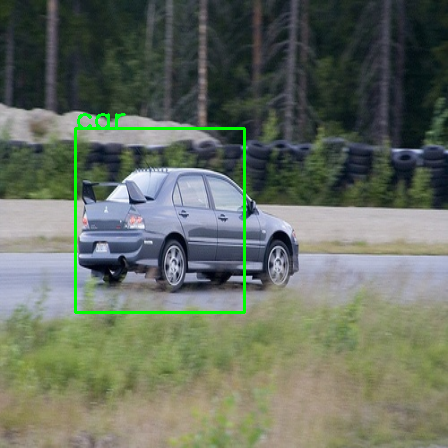

In [195]:
row = 3
column = 2

w = (out[0,row,column,23])/7
h = (out[0,row,column,24])/7
x = (out[0,row,column,21] + column) /7
y = (out[0,row,column,22] + row)/7

"""w1 = (out[1,3,3,23])/7
h1 = (out[1,3,3,24])/7
x1 = (out[1,3,3,22] + 3) /7
y1 = (out[1,3,3,23] + 3)/7
"""
b = np.array([[6, x.item(), y.item(), w.item(), h.item()]])

draw_box(image_disp[25], b)

In [198]:
for i in range(out.shape[1]):
  for j in range(out.shape[2]):
    if out[1,i,j,20] > 0.4:
      print(i,j)

3 3


In [203]:
torch.argmax(out[1,3,3,0:19])

tensor(14, device='cuda:0')

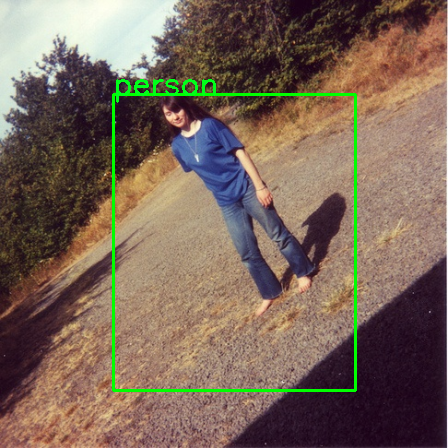

In [201]:
row = 3
column = 3

w = (out[1,row,column,23])/7
h = (out[1,row,column,24])/7
x = (out[1,row,column,21] + column) /7
y = (out[1,row,column,22] + row)/7

"""w1 = (out[1,3,3,23])/7
h1 = (out[1,3,3,24])/7
x1 = (out[1,3,3,22] + 3) /7
y1 = (out[1,3,3,23] + 3)/7
"""
b = np.array([[14, x.item(), y.item(), w.item(), h.item()]])

draw_box(image_disp[26], b)